# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys
import json

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
print(sys.path)

['', '/casa/host/src/development/casa-distro/master/python', '/casa/host/src/populse/populse_db/master/python', '/casa/host/src/capsul/master', '/casa/host/build/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/volatile/jc225751/Runs/33_MIDL_2022_reviews/Program/venv/lib/python3.6/site-packages', '/volatile/jc225751/Runs/33_MIDL_2022_reviews/Program/2021_jchavas_lguillon_deepcingulate', '/casa/home/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/casa/home/.ipython', '/volatile/jc225751/Runs/33_MIDL_2022_reviews/Program/2021_jchavas_lguillon_deepcingulate/SimCLR']


In [59]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [3]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [131]:
# Path the crops
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/tissier_2018/Rcrops/'

# Path to Tissier embeddings, created using loop_validate_clusterize_tissier.py
result_dir = '/host/volatile/jc225751/Runs/33_MIDL_2022_reviews/Output/t-0.1-analysis_tissier/n-004_o-4'

# Path to first half of hcp embeddings, created using loop_validate_clusterize.py
hcp_dir = '/host/volatile/jc225751/Runs/33_MIDL_2022_reviews/Output/t-0.1/n-004_o-4'

# Path To dir containing Tissier csv file with labels
input_dir = '/neurospin/dico/data/deep_folding/papers/midl2022/datasets/ACC_patterns'

In [ ]:
# If true, meshes are saved as files
save_mesh = False

# if true, buckets are saved as files
save_bucket = False

In [63]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [64]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# Loading of subjects's embeddings and corresponding labels
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [31]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [32]:
# We load the embeddings

val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(val_embeddings_file)
print(embeddings.shape)

torch.Size([82, 4])


In [36]:
# We load the labels, labels being subject names
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    labels = json.load(f)
print(labels)

['e0032', 'e0063', 'a0014', 'e0071', 'e0045', 'a0035', 'e0058', 'a0024', 'e0035', 'a0012', 'e0080', 'e0075', 'a0026', 'e0078', 'e0054', 'e0042', 'a0011', 'a0015', 'e0081', 'e0082', 'a0025', 'a0020', 'a0032', 'a0013', 'a0030', 'a0033', 'a0034', 'a0036', 'e0076', 'e0069', 'e0064', 'a0008', 'e0079', 'e0068', 'a0004', 'a0037', 'a0038', 'a0018', 'a0021', 'e0070', 'a0022', 'e0059', 'a0003', 'e0036', 'e0072', 'e0062', 'a0019', 'a0040', 'e0048', 'e0049', 'e0067', 'a0002', 'e0050', 'e0083', 'e0073', 'a0006', 'a0009', 'a0005', 'a0028', 'e0051', 'a0007', 'e0061', 'e0065', 'a0039', 'e0041', 'a0010', 'e0004', 'a0017', 'e0077', 'e0039', 'e0074', 'e0013', 'a0027', 'e0053', 'a0031', 'a0001', 'e0047', 'a0029', 'e0021', 'e0066', 'a0016', 'a0023']


In [264]:
# We load the csv file containing labels (presence or not of parcacingulate sulcus)
tissier_labels = pd.read_csv(f"{input_dir}/tissier_labels.csv")

In [265]:
tissier_labels.head()

,Sujet,OTS_left_continuous,OTS_left_interrupted_ant,OTS_left_interrupted_post,OTS_right_continuous,OTS_right_interrupted_ant,OTS_right_interrupted_post,ACC_left_3_levels_new,ACC_left_inter,ACC_right_3levels_new,...,ACC_right_3levels_ct,ACC_right_PCS_lenght_1rst_segment,ACC_interruption_1.1,ACC_right_PCS_lenght_2nd_segment,ACC_right_PCS_lenght_total,ACC_left_2level,ACC_right_2level,ACC_Asym3_from2,ACC_Asym3_from3,ACC_Asym2_from2
0,a0012,yes,no,no,yes,no,no,proeminent,non,absent,...,48.0,48.0,48.0,36.0,36.0,36.0,36.0,0,0,0
1,a0018,yes,no,no,no,no,yes,present,non,absent,...,48.0,48.0,36.0,36.0,36.0,36.0,0.0,0,0,460
2,a0019,yes,no,no,no,yes,no,absent,NaN,present,...,9.0,76.0,9.0,89.0,0.0,0.0,0.0,13,0,absent
3,a0022,no,no,yes,yes,no,no,proeminent,non,absent,...,11.0,9.0,11.0,4.0,1.0,0.0,0.0,5,1,proeminent
4,a0023,no,no,yes,no,no,yes,present,non,absent,...,NaN,14.0,1.0,15.0,54.0,0.0,0.0,1,53,0


In [266]:
tissier_ACC = tissier_labels[['Sujet', 'ACC_right_2levels_new', 'ACC_left_2_levels_new']]

In [267]:
tissier_ACC.head()

,Sujet,ACC_right_2levels_new,ACC_left_2_levels_new
0,a0012,absent,present
1,a0018,absent,present
2,a0019,present,absent
3,a0022,absent,present
4,a0023,absent,present


In [268]:
tissier_ACC.ACC_right_2levels_new.replace(to_replace=dict(absent=0, present=1), inplace=True)

In [269]:
tissier_ACC.ACC_left_2_levels_new.replace(to_replace=dict(absent=0, present=1), inplace=True)

In [270]:
tissier_ACC.head()

,Sujet,ACC_right_2levels_new,ACC_left_2_levels_new
0,a0012,0,1
1,a0018,0,1
2,a0019,1,0
3,a0022,0,1
4,a0023,0,1


In [271]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_
clusters_centroids = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(embeddings, cluster_labels)}")


clusters centroids = (3, 4)
Average silhouette score: 0.42013081908226013


In [272]:
dstrb_sub = pd.DataFrame(embeddings.numpy(), index=labels, columns=[1, 2, 3, 4])
dstrb_sub['cluster_lab'] = cluster_labels

ValueError: Shape of passed values is (4, 38), indices imply (4, 82)

In [273]:
dstrb_sub.head()

,1,2,3,4,cluster_lab
e0032,-1.648452,6.318245,14.644456,10.087028,1
e0063,-0.853064,6.182405,5.615448,5.258887,2
a0014,-0.833170,1.243702,-2.275604,6.295847,2
e0071,-1.309242,-0.885168,5.293868,4.589950,0
e0045,-1.563387,4.131615,12.250484,6.313830,1


In [362]:
tissier_ACC.Sujet[0:3]

0    a0012
1    a0018
2    a0019
Name: Sujet, dtype: object

In [274]:
m2 = pd.merge(dstrb_sub, tissier_ACC, left_on=dstrb_sub.index, right_on=tissier_ACC.Sujet)

In [275]:
m2.head()

,key_0,1,2,3,4,cluster_lab,Sujet,ACC_right_2levels_new,ACC_left_2_levels_new
0,e0032,-1.648452,6.318245,14.644456,10.087028,1,e0032,1,0
1,e0063,-0.853064,6.182405,5.615448,5.258887,2,e0063,0,1
2,e0045,-1.563387,4.131615,12.250484,6.313830,1,e0045,1,0
3,a0035,-1.061304,7.542898,8.391509,9.325624,1,a0035,1,0
4,e0058,-0.911376,4.336925,4.657456,2.046926,2,e0058,1,1


In [276]:
m2 = m2.set_index('Sujet')
m2 = m2.drop('key_0', 1)

In [277]:
m2.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
e0032,-1.648452,6.318245,14.644456,10.087028,1,1,0
e0063,-0.853064,6.182405,5.615448,5.258887,2,0,1
e0045,-1.563387,4.131615,12.250484,6.313830,1,1,0
a0035,-1.061304,7.542898,8.391509,9.325624,1,1,0
e0058,-0.911376,4.336925,4.657456,2.046926,2,1,1


In [278]:
dstrb_sub.shape

(82, 5)

In [279]:
m2.shape

(38, 7)

# Visualizations

We first visualize on two first dimensions of the latent space

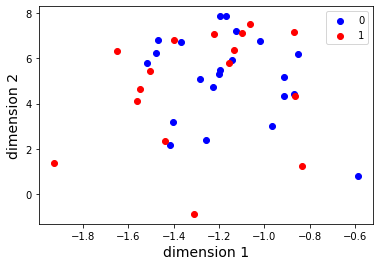

In [280]:
arr = np.array([np.array([dstrb_sub[k][i] for k in m2.columns[0:2]]) for i in range(len(m2))])

color_dict = {0: 'blue', 1:'red'}
fig, ax = plt.subplots()

for g in np.unique([m2.ACC_right_2levels_new]):
    ix = np.where(m2.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.legend()
plt.show()

We then perform a t-SNE and visualize the results with labels

In [281]:
m2_latent = m2.iloc[:,0:4]

In [282]:
m2_latent.head()

,1,2,3,4
Sujet,,,,
e0032,-1.648452,6.318245,14.644456,10.087028
e0063,-0.853064,6.182405,5.615448,5.258887
e0045,-1.563387,4.131615,12.250484,6.313830
a0035,-1.061304,7.542898,8.391509,9.325624
e0058,-0.911376,4.336925,4.657456,2.046926


In [283]:
type(m2_latent)

pandas.core.frame.DataFrame

In [284]:
embeddings = torch.tensor(m2_latent.values)

In [285]:
embeddings[:10]

tensor([[-1.6485,  6.3182, 14.6445, 10.0870],
        [-0.8531,  6.1824,  5.6154,  5.2589],
        [-1.5634,  4.1316, 12.2505,  6.3138],
        [-1.0613,  7.5429,  8.3915,  9.3256],
        [-0.9114,  4.3369,  4.6575,  2.0469],
        [-1.1710,  7.8636, 10.6115, 10.6092],
        [-0.8680,  4.4419,  2.3224,  1.7245],
        [-1.1555,  5.8157, 11.4687,  6.0536],
        [-1.3984,  6.8272,  8.5791, 10.6302],
        [-0.8707,  7.1778,  8.6492,  7.5491]])

In [286]:
tsne = TSNE(n_components=2, perplexity=5, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [287]:
lab_acc = list(m2['ACC_right_2levels_new'])
color_acc = [color_dict[lab] for lab in lab_acc]

In [288]:
lab_acc_left = list(m2['ACC_left_2_levels_new'])
color_acc_left = [color_dict[lab] for lab in lab_acc_left]

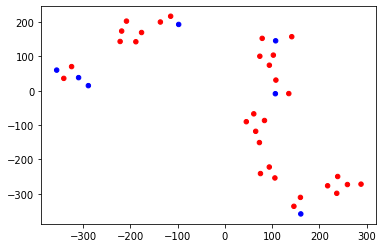

In [289]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=color_acc_left, s=20, ax=ax)
plt.show()

# Get HCP data and put them together with Tissier data

In [290]:
# We load the hcp embeddings

val_embeddings_file = f"{hcp_dir}/train_val_embeddings.pt"
hcp_embeddings = torch.load(val_embeddings_file)
print(hcp_embeddings.shape)

torch.Size([550, 4])


In [291]:
# We load the labels, labels being subject names
with open(f"{hcp_dir}/train_val_filenames.json", 'r') as f:
    hcp_labels = json.load(f)
print(hcp_labels[:10])

['129634', '136833', '206222', '138837', '987983', '562345', '182032', '275645', '151021', '177342']


In [292]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne_hcp = tsne.fit_transform(hcp_embeddings)

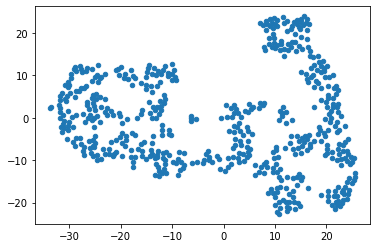

In [293]:
fig, ax = plt.subplots(1)
mscatter(X_tsne_hcp[:, 0], X_tsne_hcp[:, 1], s=20, ax=ax)
plt.show()

In [294]:
hcp_df = pd.DataFrame(hcp_embeddings.numpy(), index=hcp_labels, columns=[1, 2, 3, 4])

In [295]:
hcp_df["cluster_lab"] = -1
hcp_df["ACC_right_2levels_new"] = -1
hcp_df["ACC_left_2_levels_new"] = -1

In [296]:
hcp_df.shape

(550, 7)

In [297]:
hcp_df.index.names = ['Sujet']

In [298]:
hcp_df.shape

(550, 7)

In [299]:
hcp_df.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
129634,-1.579225,5.908354,11.362507,9.859923,-1,-1,-1
136833,-1.279658,7.395753,10.953645,10.460653,-1,-1,-1
206222,-1.124506,1.848059,1.461904,5.974949,-1,-1,-1
138837,-1.068878,5.266653,0.712424,4.285092,-1,-1,-1
987983,-0.843226,3.528162,4.100409,-0.345357,-1,-1,-1


In [300]:
m2.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
e0032,-1.648452,6.318245,14.644456,10.087028,1,1,0
e0063,-0.853064,6.182405,5.615448,5.258887,2,0,1
e0045,-1.563387,4.131615,12.250484,6.313830,1,1,0
a0035,-1.061304,7.542898,8.391509,9.325624,1,1,0
e0058,-0.911376,4.336925,4.657456,2.046926,2,1,1


In [301]:
all_df = hcp_df

In [302]:
all_df.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
129634,-1.579225,5.908354,11.362507,9.859923,-1,-1,-1
136833,-1.279658,7.395753,10.953645,10.460653,-1,-1,-1
206222,-1.124506,1.848059,1.461904,5.974949,-1,-1,-1
138837,-1.068878,5.266653,0.712424,4.285092,-1,-1,-1
987983,-0.843226,3.528162,4.100409,-0.345357,-1,-1,-1


In [303]:
all_df.shape

(550, 7)

In [304]:
all_df = all_df.append(m2)

In [305]:
all_df.shape

(588, 7)

In [306]:
all_df.iloc[-1,:]

1                       -1.140249
2                        5.084541
3                        7.872952
4                        4.696342
cluster_lab              0.000000
ACC_right_2levels_new    0.000000
ACC_left_2_levels_new    1.000000
Name: a0023, dtype: float64

In [307]:
all_df_latent = all_df.iloc[:,0:4]

In [308]:
all_embeddings = torch.tensor(all_df_latent.values)

In [309]:
all_embeddings.shape

torch.Size([588, 4])

In [310]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne_all = tsne.fit_transform(all_embeddings)

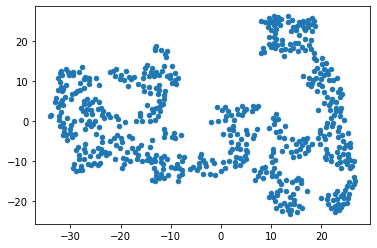

In [311]:
fig, ax = plt.subplots(1)
mscatter(X_tsne_all[:, 0], X_tsne_all[:, 1], s=20, ax=ax)
plt.show()

In [312]:
color_dict_all = {0: 'blue', 1:'red', -1: 'yellow'}

In [313]:
lab_all_acc = list(all_df['ACC_right_2levels_new'])
color_all_acc = [color_dict_all[lab] for lab in lab_all_acc]

In [314]:
lab_all_left_acc = list(all_df['ACC_left_2_levels_new'])
color_all_left_acc = [color_dict_all[lab] for lab in lab_all_left_acc]

Correlated with right Acc paracingular labels

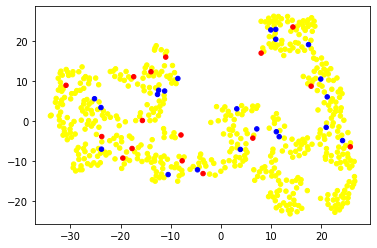

In [315]:
fig, ax = plt.subplots(1)
mscatter(X_tsne_all[:, 0], X_tsne_all[:, 1], c=color_all_acc, s=20, ax=ax)
plt.show()

Correlated with left Acc paracingular labels

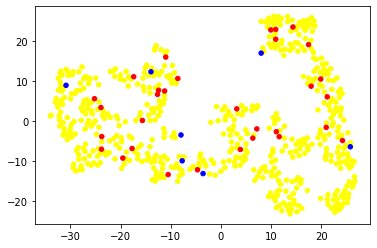

In [316]:
fig, ax = plt.subplots(1)
mscatter(X_tsne_all[:, 0], X_tsne_all[:, 1], c=color_all_left_acc, s=20, ax=ax)
plt.show()

In [317]:
all_df.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
129634,-1.579225,5.908354,11.362507,9.859923,-1,-1,-1
136833,-1.279658,7.395753,10.953645,10.460653,-1,-1,-1
206222,-1.124506,1.848059,1.461904,5.974949,-1,-1,-1
138837,-1.068878,5.266653,0.712424,4.285092,-1,-1,-1
987983,-0.843226,3.528162,4.100409,-0.345357,-1,-1,-1


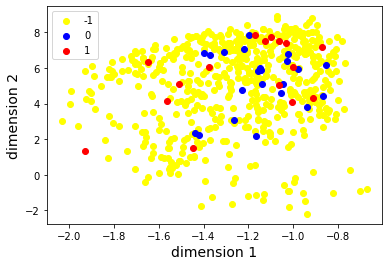

In [318]:
arr = np.array([np.array([all_df[k][i] for k in all_df.columns[0:2]]) for i in range(len(all_df))])

fig, ax = plt.subplots()

for g in np.unique([all_df.ACC_right_2levels_new]):
    ix = np.where(all_df.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict_all[g], label = g)

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.legend()
plt.show()

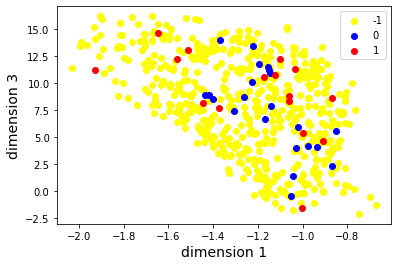

In [319]:
arr = np.array([np.array([all_df[k][i] for k in all_df.columns[[0,2]]]) for i in range(len(all_df))])

fig, ax = plt.subplots()

for g in np.unique([all_df.ACC_right_2levels_new]):
    ix = np.where(all_df.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict_all[g], label = g)

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 3', fontsize=14)
plt.legend()
plt.show()

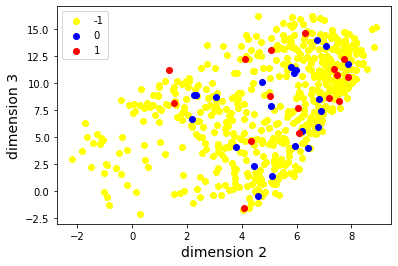

In [320]:
arr = np.array([np.array([all_df[k][i] for k in all_df.columns[1:3]]) for i in range(len(all_df))])

fig, ax = plt.subplots()

for g in np.unique([all_df.ACC_right_2levels_new]):
    ix = np.where(all_df.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict_all[g], label = g)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 3', fontsize=14)
plt.legend()
plt.show()

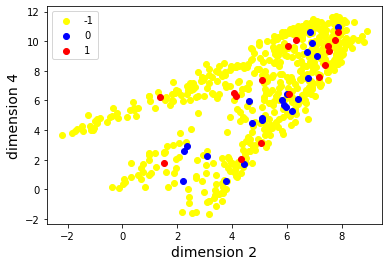

In [321]:
arr = np.array([np.array([all_df[k][i] for k in all_df.columns[[1,3]]]) for i in range(len(all_df))])

fig, ax = plt.subplots()

for g in np.unique([all_df.ACC_right_2levels_new]):
    ix = np.where(all_df.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict_all[g], label = g)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.legend()
plt.show()

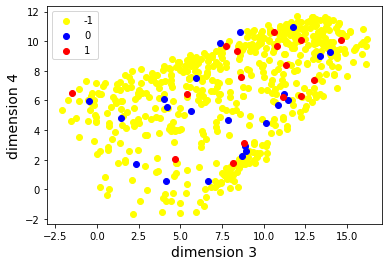

In [322]:
arr = np.array([np.array([all_df[k][i] for k in all_df.columns[2:4]]) for i in range(len(all_df))])

fig, ax = plt.subplots()

for g in np.unique([all_df.ACC_right_2levels_new]):
    ix = np.where(all_df.ACC_right_2levels_new == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict_all[g], label = g)

plt.xlabel(f'dimension 3', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.legend()
plt.show()

# Classification tests with Tissier database and cross-validation

## SVM test

In [323]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm

In [370]:
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))

In [371]:
m2.head()

,1,2,3,4,cluster_lab,ACC_right_2levels_new,ACC_left_2_levels_new
Sujet,,,,,,,
e0032,-1.648452,6.318245,14.644456,10.087028,1,1,0
e0063,-0.853064,6.182405,5.615448,5.258887,2,0,1
e0045,-1.563387,4.131615,12.250484,6.313830,1,1,0
a0035,-1.061304,7.542898,8.391509,9.325624,1,1,0
e0058,-0.911376,4.336925,4.657456,2.046926,2,1,1


In [372]:
X = m2.iloc[:,0:4].values

In [373]:
y = m2.ACC_right_2levels_new.values
y

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

In [374]:
y_shuffle = m2.ACC_right_2levels_new.values.copy()
np.random.shuffle(y_shuffle)
y_shuffle

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1])

In [375]:
y

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

In [376]:
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.66666667 0.875      0.57142857 0.57142857 0.57142857]
0.65 accuracy with a standard deviation of 0.12


In [333]:
scores_shuffle = cross_val_score(clf, X, y_shuffle, cv=5)
print(scores_shuffle)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_shuffle.mean(), scores_shuffle.std()))

[0.55555556 0.625      0.42857143 0.42857143 0.71428571]
0.55 accuracy with a standard deviation of 0.11


In [337]:
# We do the scoring only on the best two dimensions of the latent
X_2_4 = X[:,[1,3]]
print(X[:3])
print(X_2_4[:3])

[[-1.6484517   6.3182454  14.644456   10.087028  ]
 [-0.85306376  6.1824055   5.6154485   5.2588873 ]
 [-1.5633868   4.131615   12.250484    6.31383   ]]
[[ 6.3182454 10.087028 ]
 [ 6.1824055  5.2588873]
 [ 4.131615   6.31383  ]]


In [339]:
scores_2_4 = cross_val_score(clf, X_2_4, y, cv=5)
print(scores_2_4)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_2_4.mean(), scores_2_4.std()))

[0.55555556 0.875      0.57142857 0.71428571 0.71428571]
0.69 accuracy with a standard deviation of 0.12


## Logistic regression

In [340]:
from sklearn.linear_model import LogisticRegression

In [346]:
clf_logit = LogisticRegression(solver='liblinear', random_state=0)

In [348]:
scores_logit = cross_val_score(clf_logit, X, y, cv=5)
print(scores_logit)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_logit.mean(), scores_logit.std()))

[0.66666667 0.75       0.57142857 0.71428571 0.57142857]
0.65 accuracy with a standard deviation of 0.07


In [358]:
scores_logit_shuffle = cross_val_score(clf_logit, X, y_shuffle, cv=5)
print(scores_logit_shuffle)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_logit_shuffle.mean(), scores_logit_shuffle.std()))

[0.55555556 0.625      0.57142857 0.42857143 0.57142857]
0.55 accuracy with a standard deviation of 0.07


## Gradient boosting classifier

In [350]:
from sklearn.ensemble import GradientBoostingClassifier

In [355]:
clf_gdb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [356]:
scores_gdb = cross_val_score(clf_gdb, X, y, cv=5)
print(scores_gdb)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_gdb.mean(), scores_gdb.std()))

[0.77777778 0.625      0.42857143 0.85714286 0.71428571]
0.68 accuracy with a standard deviation of 0.15
